In [33]:
import os
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

# Test

---

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [35]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

batch_size = 32

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [36]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


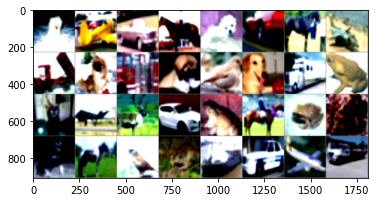

  dogplane  carhorse  dog  carhorseplanetruck  dogtruck  dog bird  dogtruck frog  catplane deer  car froghorse frog frog  doghorse bird frog ship  carplanetruck


In [37]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [38]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super().__init__()

        '''
        torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride,
            padding, padding_mode, dilation, groups, bias
            )

        torch.nn.ReLU(
            inplace     : 출력을 할당하지 않고 입력을 직접 수정
            )
        '''
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=96),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=384),

            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=384),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),

            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [39]:
alexNet = AlexNet(len(classes))
alexNet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d

In [41]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexNet.parameters(), lr=0.001)

In [43]:
minimum_updates = 1000
minibatches_proccesed = 0
best_model_loss = 1e20
best_model_minibatch_time = 0
isStop = False
eval_interval = 100
PATH = './alexnet.pth'

epoch = 0
while not isStop:
    running_loss = 0.0
    running_accuracy = 0.0

    optimizer.zero_grad()
    alexNet.zero_grad()

    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte/59013131
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = alexNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()
        alexNet.zero_grad()

        # 통계를 출력합니다.
        preds = torch.argmax(outputs.data, dim=1)

        running_loss += loss.item()
        running_accuracy += (labels == preds).float().mean()

        minibatches_proccesed += 1

        if minibatches_proccesed % eval_interval == (eval_interval - 1):
            if running_loss < best_model_loss and (running_accuracy / eval_interval) >= 0.7:
                best_model_loss = running_loss
                best_model_minibatch_time = minibatches_proccesed
                torch.save(alexNet.state_dict(), PATH)

            if minibatches_proccesed > minimum_updates and minibatches_proccesed >= best_model_minibatch_time + minimum_updates:
                isStop = True

            print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, minibatches_proccesed + 1, running_loss / eval_interval, running_accuracy / eval_interval))
            running_loss = 0.0
            running_accuracy = 0.0
            
    epoch += 1

print('Finished Training')

[1,   100] loss: 2.083, accuracy: 0.278
[1,   200] loss: 2.125, accuracy: 0.266
[1,   300] loss: 2.053, accuracy: 0.285
[1,   400] loss: 2.015, accuracy: 0.291
[1,   500] loss: 1.985, accuracy: 0.295
[1,   600] loss: 1.926, accuracy: 0.318
[1,   700] loss: 2.040, accuracy: 0.274
[1,   800] loss: 1.983, accuracy: 0.297
[1,   900] loss: 1.955, accuracy: 0.305
[1,  1000] loss: 1.892, accuracy: 0.324
[1,  1100] loss: 1.822, accuracy: 0.357
[1,  1200] loss: 1.804, accuracy: 0.347
[1,  1300] loss: 1.824, accuracy: 0.343
[1,  1400] loss: 1.781, accuracy: 0.363
[1,  1500] loss: 1.793, accuracy: 0.357
[2,  1600] loss: 0.619, accuracy: 0.129
[2,  1700] loss: 1.715, accuracy: 0.372
[2,  1800] loss: 1.715, accuracy: 0.389
[2,  1900] loss: 1.719, accuracy: 0.380
[2,  2000] loss: 1.669, accuracy: 0.409
[2,  2100] loss: 1.621, accuracy: 0.406
[2,  2200] loss: 1.611, accuracy: 0.420
[2,  2300] loss: 1.594, accuracy: 0.429
[2,  2400] loss: 1.613, accuracy: 0.428
[2,  2500] loss: 1.543, accuracy: 0.445


KeyboardInterrupt: 

In [25]:
torch.save(alexNet.state_dict(), PATH)

In [26]:
PATH = './alexnet.pth'
torch.save(alexNet.state_dict(), PATH)

In [27]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [44]:
PATH = './alexnet.pth'
alexNet = AlexNet(len(classes))
alexNet.load_state_dict(torch.load(PATH))
alexNet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d

In [45]:
outputs = alexNet(images.cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


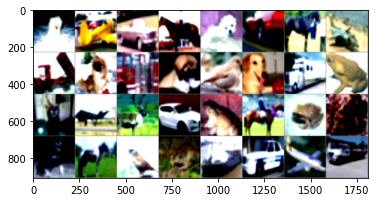

GroundTruth:   ship  bird   cat plane   cat  ship plane horse  bird  frog   cat horse  deer   car truck  ship truck  frog  deer  ship   cat  ship   cat  deer  deer  bird plane   car  ship plane horse truck
Predicted:    dog plane   car horse   dog   car horse plane truck   dog truck   dog  bird   dog truck  frog   cat plane  deer   car  frog horse  frog  frog   dog horse  bird  frog  ship   car plane truck


In [46]:
_, predicted = torch.max(outputs, 1)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

In [47]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = alexNet(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


In [48]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        outputs = alexNet(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 86.0 %
Accuracy for class car   is: 87.0 %
Accuracy for class bird  is: 72.5 %
Accuracy for class cat   is: 68.1 %
Accuracy for class deer  is: 70.9 %
Accuracy for class dog   is: 73.5 %
Accuracy for class frog  is: 86.7 %
Accuracy for class horse is: 78.6 %
Accuracy for class ship  is: 89.5 %
Accuracy for class truck is: 88.1 %
